In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from matplotlib.lines import Line2D
from nff.io.ase_calcs import EnsembleNFF, NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.decomposition import PCA
from tqdm import tqdm

from mcmc.calculators import get_embeddings_single, get_results_single, get_std_devs_single
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import DEFAULT_DPI

/home/dux/NeuralForceField/models


Load neural network force field. We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039).

In [3]:
DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"
NFF_CUTOFF = 5.0

# requires an ensemble of models in this path
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/SrTiO3_001/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

# EnsembleNFF for force standard deviation prediction
ensemble_calc = EnsembleNFF(
    models,
    device=DEVICE,
    model_units="kcal/mol",
    prediction_units="eV",
)
# NeuralFF for latent space embedding calculation
single_calc = NeuralFF(
    models[0],
    device=DEVICE,
    model_units="kcal/mol",
    prediction_units="eV",
    properties=["energy", "forces", "embedding"],
)

Load surfaces previously obtained from VSSR-MC

In [4]:
with open("data/SrTiO3_001/SrTiO3_001_2x2_mcmc_structures_100.pkl", "rb") as f:
    dataset = pickle.load(f)

print(f"Final dataset has {len(dataset)} entries")

Final dataset has 100 entries


Extract embeddings and force standard deviation as the metric value for clustering

In [5]:
embeddings = []
metric_values = []
for single_dset in tqdm(dataset):
    atoms_batch = get_atoms_batch(single_dset, NFF_CUTOFF, device=DEVICE)
    single_calc_results = get_results_single(atoms_batch, single_calc)
    embedding = get_embeddings_single(
        atoms_batch,
        single_calc,
        results_cache=single_calc_results,
        flatten=True,
        flatten_axis=0,
    )
    metric_value = get_std_devs_single(atoms_batch, ensemble_calc)
    embeddings.append(embedding)
    metric_values.append(metric_value)
embeddings = np.stack(embeddings)
metric_values = np.stack(metric_values)

100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Obtain PCA

In [6]:
X_embeddings = np.stack(embeddings)

pca = PCA(n_components=32, whiten=True).fit(X_embeddings)

print(f"The pca explained ratios are {pca.explained_variance_ratio_[:5]}...")

# transform train
X_r = pca.transform(X_embeddings)

The pca explained ratios are [0.70155203 0.25356615 0.01665298 0.00797125 0.00539697]...


Do clustering

In [7]:
Z = linkage(X_r[:, :3], method="ward", metric="euclidean", optimal_ordering=True)
y = fcluster(Z, t=2, criterion="distance", depth=2)  # t sets the distance
clusters = np.unique(y)
max_index = np.max(clusters)

print(f"There are {len(clusters)} clusters")

There are 14 clusters


Visualize with dendrogram

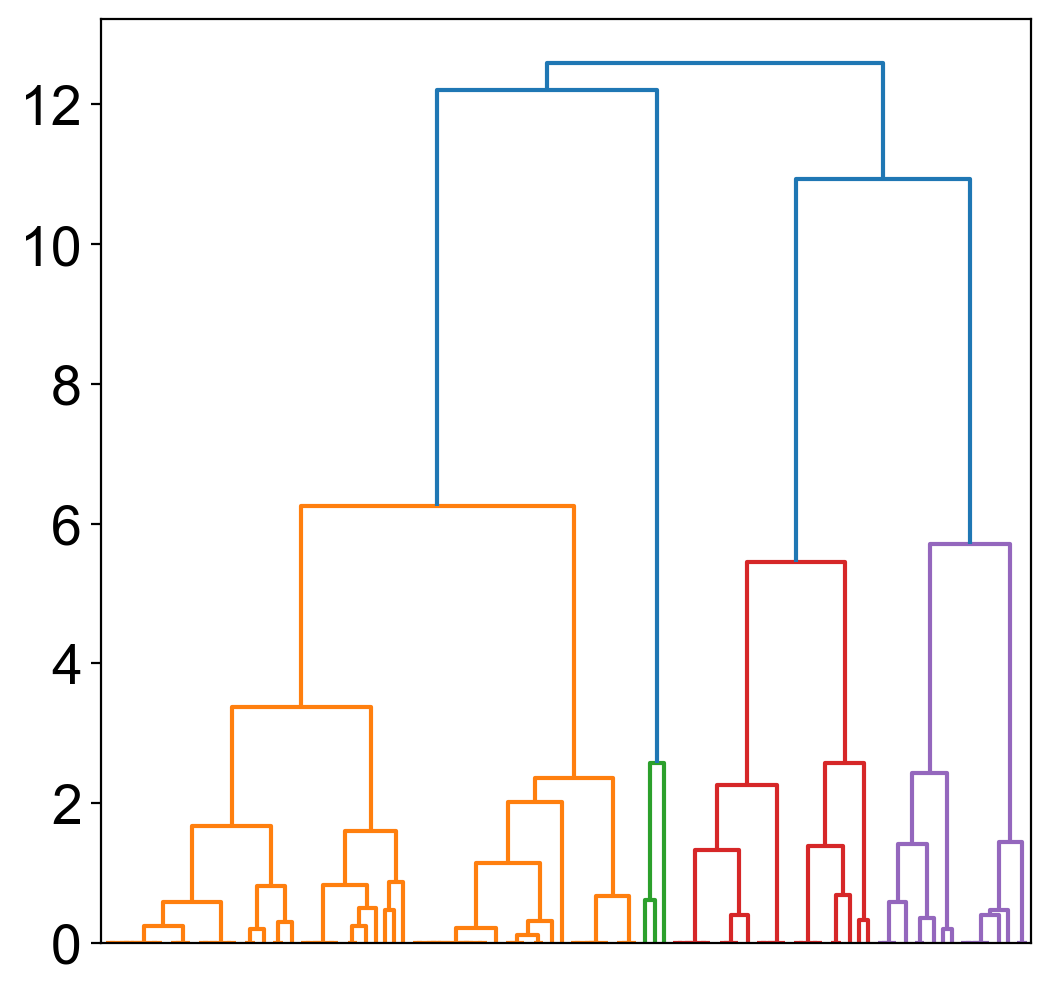

In [8]:
fig = plt.figure(figsize=(6, 6), dpi=DEFAULT_DPI)
dn = dendrogram(
    Z,
    truncate_mode="level",
    show_leaf_counts=False,
    no_labels=True,
    count_sort="descending",
)
plt.show()

Find structure with the highest variance per cluster

In [9]:
data = {"cluster": y, "force_std": metric_values}

cluster_df = pd.DataFrame(data).reset_index()

max_std_df = (
    cluster_df.sort_values(["cluster", "force_std"], ascending=[True, False])
    .groupby("cluster", as_index=False)
    .first()
)

PCA plot with the highest variance structure per cluster

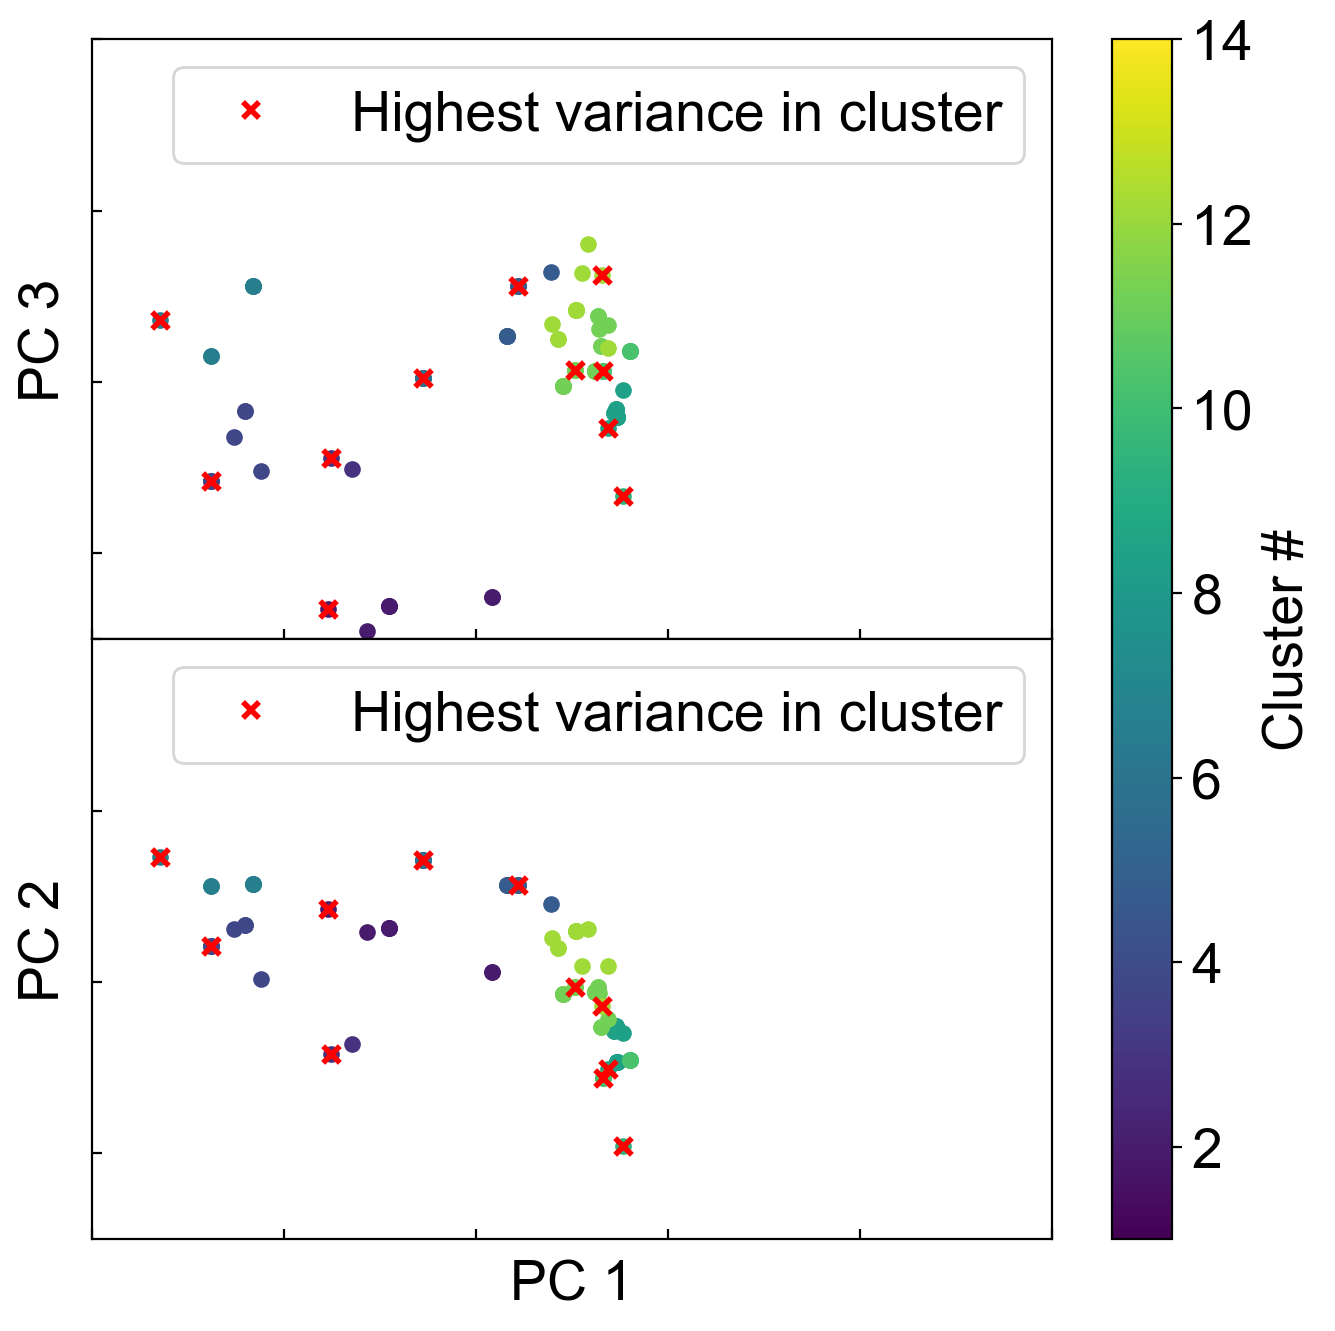

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, dpi=DEFAULT_DPI)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)

for cluster in clusters:
    axes[1].scatter(
        X_r[y == cluster, 0],
        X_r[y == cluster, 1],
        edgecolors=None,
        linewidths=0,
        color=mpl.cm.viridis(cluster / max_index),
    )
    axes[0].scatter(
        X_r[y == cluster, 0],
        X_r[y == cluster, 2],
        edgecolors=None,
        linewidths=0,
        color=mpl.cm.viridis(cluster / max_index),
    )

# highlight max variance per cluster
for idx in max_std_df["index"]:
    axes[1].scatter(X_r[idx, 0], X_r[idx, 1], linewidths=2, color="r", marker="x")
    axes[0].scatter(X_r[idx, 0], X_r[idx, 2], linewidths=2, color="r", marker="x")

for ax in axes:
    # increase tick size and make them point inwards
    ax.tick_params(
        axis="y",
        direction="in",
    )
    ax.tick_params(
        axis="x",
        direction="in",
    )

# set axes for first plot
axes[0].set_ylabel("PC 3")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_xlim([-2, 3])
axes[0].set_ylim([-3, 4])

# set axes for second plot
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")
axes[1].set_yticklabels([])
axes[1].set_ylim([-3, 4])

norm = mpl.colors.Normalize(vmin=min(clusters), vmax=max(clusters))
cb = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap="viridis"),
    ax=axes.ravel().tolist(),
    shrink=1.00,
)
cb.set_label(r"Cluster #")

cb.ax.tick_params(
    axis="both",
    which="major",
)
cb.ax.tick_params(
    axis="both",
    which="minor",
)

scatter_leg = (
    Line2D(
        [0],
        [0],
        marker="x",
        lw=0,
        markeredgewidth=2,
        markeredgecolor="r",
    ),
)

labels = ["Highest variance in cluster"]
handles = scatter_leg

for ax in axes:
    ax.legend(handles, labels, loc="best", frameon=True)

plt.show()
plt.close()